In [14]:
import torch
import cv2
import matplotlib.pyplot as plt
import os
import torchvision.models as models
from roboflow import Roboflow

## Data

In [ ]:
# lấy ảnh (tên ảnh, xmin, ymin, xmax, ymax, label: 0-fire, 1-smoke)
def get_annotations (file_path):
    # tuple
    annotations = [] 
    with open(file_path, 'r') as file:
        for line in file: 
            line = line.strip() # chia theo \n
            if not line:
                continue

            parts = line.split(' ') # chia theo dấu ' '
            image_name = parts[0]
            bbox_info_list = parts[1:]

            for bbox_info in bbox_info_list:
                x_min, y_min, x_max, y_max, label = map(int, bbox_info.split(','))
                annotations.append((image_name, x_min, y_min, x_max, y_max, label))

    return annotations
        
annotations_train_file = './data/fire/train/_annotations.txt'
annotations_train = get_annotations(annotations_train_file)
print(annotations_train[0])

('IMG_20220622_105625_8_jpg.rf.095fb619de1e9fdc6cd729e4a7134877.jpg', 217, 153, 283, 272, 0)


(np.float64(-0.5), np.float64(415.5), np.float64(415.5), np.float64(-0.5))

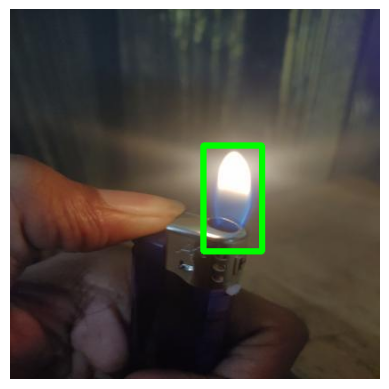

In [29]:
fist_img = annotations_train[0]
img = cv2.imread(f"./data/fire/train/{fist_img[0]}")

cv2.rectangle(img, (fist_img[1], fist_img[2]), (fist_img[3], fist_img[4]), color=(0,255,0), thickness=5)

plt.imshow(img[:,:,::-1])
plt.axis('off')

In [ ]:
def preprocess_img (annotations, resize):
    preprocessed_img = []
    for annotation in annotations:
        img = cv2.imread(f"./data/fire/train/{annotation[0]}")
        resized_img = cv2.resize(img, (resize, resize)) # 448*448*3 phù hợp với đầu vào vgg16
        normalized_img = resized_img/255.0
        preprocessed_img.append(normalized_img, annotation[1:])
    return preprocessed_img

def convert_to_label_yolo (annotations, S, resize):
    yolo_labels = []
    normalized_img = preprocess_img(annotations, resize)
    for img in normalized_img:
        w, h = img.shape[:2]
        x_min, y_min, x_max, y_max = img[1:5] # 2 góc của đối tượng trong ảnh cũ
        x_center = ((x_min + x_max) / 2 / w)
        y_center = ((y_min + y_max) / 2 / h)
        w_bb = (x_max - x_min) / w
        h_bb = (y_max - y_min) / h
        label = img[5]
        yolo_labels.append(1, x_center, y_center, w_bb, h_bb, label)

## Model

In [ ]:
backbone = models.vgg16(pretrained=True)
backbone = torch.nn.Sequential(*list(backbone.children())[:-2]) # Output: (Batch, 512, 14, 14)

In [ ]:
class YOLOv1(torch.nn.Module):
    def __init__ (self, backbone):
        super.__init__()
        self.backbone = backbone # sequential

        # head
        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv2d(512, 1024, kernel_size=3, padding=1), # mở rộng đặc trưng
            torch.nn.LeakyReLU(0.1),
            torch.nn.Conv2d(1024, 1024, kernel_size=3, padding=1), # đi sâu hơn vào đặc trưng
            torch.nn.LeakyReLU(0.1)
        )

        self.fc_layers = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(1024 * 14 * 14, 4096), # kích thước feature map 14*14
            torch.nn.Dropout(0.5),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Linear(4096, 7 * 7 * 12) # lưới 7*7*(2 lớp + 5 tham số * 2 boxes)
        )
    
    def forward(self, x):
        x = self.backbone(x)
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x.view(-1, 7, 7, 12)

## Loss

In [ ]:
def get_obj_mask(obj_mask, target_boxes):
    cell_x = (target_boxes[..., 0])

def loss(preds, targets, lambda_coord=5, lambda_noobj=0.5):
    """
    Hàm loss cho YOLOv1.
    Args:
        predictions (Tensor): Shape (batch, 7, 7, 12) - Dự đoán của mô hình.
        targets (Tensor): Shape (batch, 7, 7, 12) - Ground truth.
        lambda_coord (float): Trọng số cho localization loss.
        lambda_noobj (float): Trọng số cho confidence loss của box không có vật thể.
    Returns:
        total_loss (Tensor): Tổng loss.
    """

    batch_size = preds.size[0]
    S = 7 # lưới
    B = preds.size[3] # anchor boxes mỗi cell

    pred_boxes = preds[..., :10].view(batch_size, S, S, B, 5) # (x, y, w, h, conf) * 2
    target_boxes = targets[..., :10].view(batch_size, S, S, B, 5)
    pred_classes = preds[..., 10:]
    target_classes = targets[..., 10:]

    obj_mask = 

## Train

In [11]:
device = torch.device("cuda")
print(torch.cuda.is_available())
print(device)

True
cuda


## Test
